In [1]:
!pip install pytorch_lightning
!pip install sentence_transformers
!pip install wandb

     |████████████████████████████████| 256kB 3.4MB/s 
     |████████████████████████████████| 829kB 10.9MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=bb480ea90ea02afbcdbe1295682fba562a321edacda4e72fa5bd782a9921bc48
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
     |████████████████████████████████| 61kB 2.1MB/s 
     |████████████████████████████████| 675kB 7.7MB/s 
     |████████████████████████████████| 1.1MB 15.7MB/s 
     |████████████████████████████████| 890kB 13.6MB/s 
     |████████████████████████████████| 3.8MB 29.8MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.6.1-cp36-none-any.whl size=74031 sha256=649b9a627e5498ecdb797851ff0c004064f246307c95f14af09ac8f8911b99f5
  Stored in directory

In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import pickle

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

import transformers
import tokenizers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

from sentence_transformers import SentenceTransformer
import transformers
from typing import List, Dict, Tuple, Iterable, Type

import wandb

from sklearn.metrics import roc_auc_score

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [0]:
class SBERT(SentenceTransformer):
    def __init__(self, model_name_or_path: str = None, device: str = None):
        super().__init__(model_name_or_path, device=device)
        print(f'Using device {self.device}')

    def smart_batching_collate(self, batch):
        """
        Transforms a batch from a SmartBatchingDataset to a batch of tensors for the model
        :param batch:
            a batch from a SmartBatchingDataset
        :return:
            a batch of tensors for the model
        """
        num_texts = len(batch[0][0])

        labels = []
        paired_texts = [[] for _ in range(num_texts)]
        max_seq_len = [0] * num_texts
        for tokens, label in batch:
            labels.append(label)
            for i in range(num_texts):
                paired_texts[i].append(tokens[i])
                max_seq_len[i] = max(max_seq_len[i], len(tokens[i]))

        features = []
        for idx in range(num_texts):
            max_len = max_seq_len[idx]
            feature_lists = {}

            for text in paired_texts[idx]:
                sentence_features = self.get_sentence_features(text, max_len)

                for feature_name in sentence_features:
                    if feature_name not in feature_lists:
                        feature_lists[feature_name] = []

                    feature_lists[feature_name].append(sentence_features[feature_name])


            for feature_name in feature_lists:
                feature_lists[feature_name] = torch.cat(feature_lists[feature_name])

            features.append(feature_lists)

        return {'features': features, 'labels': torch.stack(labels)}

    def fit(self,
            train_objective: Iterable[Tuple[torch.utils.data.DataLoader, torch.nn.Module]],
            #evaluator: SentenceEvaluator,
            epoches: int = 1,
            steps_per_epoch = None,
            scheduler: str = 'WarmupLinear',
            warmup_steps: int = 10000,
            optimizer_class: Type[torch.optim.Optimizer] = transformers.AdamW,
            optimizer_params : Dict[str, object ]= {'lr': 2e-5, 'eps': 1e-6, 'correct_bias': False},
            weight_decay: float = 0.01,
            evaluation_steps: int = 0,
            output_path: str = None,
            save_best_model: bool = True,
            max_grad_norm: float = 1,
            local_rank: int = -1
            ):
        """
        Train the model with the given training objective
        Each training objective is sampled in turn for one batch.
        We sample only as many batches from each objective as there are in the smallest one
        to make sure of equal training with each dataset.
        :param weight_decay:
        :param scheduler:
        :param warmup_steps:
        :param optimizer:
        :param evaluation_steps:
        :param output_path:
        :param save_best_model:
        :param max_grad_norm:
        :param local_rank:
        :param train_objectives:
            Tuples of DataLoader and LossConfig
        :param evaluator:
        :param epochs:
        :param steps_per_epoch: Train for x steps in each epoch. If set to None, the length of the dataset will be used
        """
        train_loader, loss_model = train_objective

        param_optimizer = list(self.named_parameters())

        #init optimizer and sheduler
        if steps_per_epoch is None or steps_per_epoch == 0:
            steps_per_epoch = len(train_loader)

        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        t_total = int(steps_per_epoch * epoches)
        if local_rank != -1:
            t_total = t_total // torch.distributed.get_world_size()

        optimizer = optimizer_class(optimizer_grouped_parameters, **optimizer_params)
        scheduler = self._get_scheduler(optimizer, scheduler=scheduler, warmup_steps=warmup_steps, t_total=t_total)

        train_loader.collate_fn = self.smart_batching_collate
        
        for ep in range(1, epoches+1):
            self.train()
            iterator = tqdm(train_loader, desc=f'Epoch {ep}', total=len(train_loader))
            batch_loss = []
            for batch in iterator:
                self.zero_grad()

                batch = batch_to_device(batch, self.device)

                #get embeddings
                seqs = [self(sentence_feature)['sentence_embedding'] for sentence_feature in batch[0]]
                seq_a, seq_b = seqs
                #pass them to the loss function
                loss_value = loss_model(seq_a, seq_b, batch[1])
                loss_value.backward()

                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

                batch_loss.append(loss_value.item())
                iterator.desc = f'Epoch {ep} Loss {sum(batch_loss)/len(batch_loss):.3}'


class SentencesDataset(Dataset):
    """
    Dataset for smart batching, that is each batch is only padded to its longest sequence instead of padding all
    sequences to the max length.
    The SentenceBertEncoder.smart_batching_collate is required for this to work.
    SmartBatchingDataset does *not* work without it.
    """
    def __init__(self, features: np.array, target: np.array, model: SBERT, show_progress_bar: bool = True):
        """
        Create a new SentencesDataset with the tokenized texts and the labels as Tensor
        """
        self.show_progress_bar = show_progress_bar
        
        self.convert_input_examples(features, target, model)

    def convert_input_examples(self, texts: np.array, targets: np.array, model: SBERT):
        """
        Converts input examples to a SmartBatchingDataset usable to train the model with
        SentenceTransformer.smart_batching_collate as the collate_fn for the DataLoader
        smart_batching_collate as collate_fn is required because it transforms the tokenized texts to the tensors.
        :param examples:
            the input examples for the training
        :param model
            the Sentence BERT model for the conversion
        :return: a SmartBatchingDataset usable to train the model with SentenceTransformer.smart_batching_collate as the collate_fn
            for the DataLoader
        """
        num_texts = len(texts)
        inputs = []
        too_long = [0] * num_texts
        iterator = texts
        max_len = model.get_max_seq_length()

        if self.show_progress_bar:
            iterator = tqdm(iterator, desc="Convert dataset")

        for text in iterator:
            tokenized_texts = model.tokenize(text)
            """
            padding_length = max_len - len(tokenized_texts)
            if padding_length > 0:
                tokenized_texts = tokenized_texts + ([0] * padding_length)
            """
            inputs.append(tokenized_texts)    

        print('')
        print("Sentences longer than max_sequence_length: {}".format(sum(too_long)))

        self.tokens = inputs
        self.labels = targets

    def __getitem__(self, item):
        return self.tokens[item], self.labels[item]

    def __len__(self):
        return len(self.tokens)

In [0]:
class SBertClassModel(pl.LightningModule):
    def __init__(self, hparams):
        super(SBertClassModel, self).__init__()
        self.hparams = hparams
        #define model layers
        self.bert = SBERT(hparams.model_path)
        self.drop = nn.Dropout(hparams.dropout_prob)
        self.lin = nn.Linear(self.bert[2].linear.out_features, hparams.num_classes)
        #define loss, metric and softmax
        self.soft = nn.Softmax(dim=1)
        self.loss_fn = nn.CrossEntropyLoss(weight=hparams.weigths, ignore_index=0) #ignoring PAD index
        self.auc = roc_auc_score
    
    def forward(self, input):
        #get sentence embeddings
        embs = self.bert(input)['sentence_embedding']

        logits = self.lin(self.drop(embs))

        return logits
    
    def prepare_data(self):
        df_train = pd.read_parquet(self.hparams.train_file_path)
        df_val = pd.read_parquet(self.hparams.val_file_path)

        self.train_ds = SentencesDataset(features=df_train['question'].to_numpy(), target=df_train.drop('question', axis=1).to_numpy(), model=self.bert)
        self.val_ds = SentencesDataset(features=df_val['question'].to_numpy(), target=df_val.drop('question', axis=1).to_numpy(), model=self.bert)

        self.num_train_steps = int(len(self.train_ds) / self.hparams.train_batch_size * self.hparams.num_epochs)
    
    def train_dataloader(self):
        loader = torch.utils.data.DataLoader(self.train_ds, collate_fn=self.smart_batching_collate,
                                             batch_size=self.hparams.train_batch_size,
                                             num_workers=4, shuffle=True)
        return loader
     
    def val_dataloader(self):
        loader = torch.utils.data.DataLoader(self.val_ds, collate_fn=self.smart_batching_collate,
                                             batch_size=self.hparams.valid_batch_size,
                                             num_workers=4)      
        return loader
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        
        preds = self(x)
        loss = self.loss_fn(preds, y)
        
        logs = {'train_loss': loss}
        
        return {'loss': logs['train_loss'], 'log': logs, 'labels': y, 'preds': preds}
    
    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()

        label = torch.cat([x['labels'] for x in outputs], dim=0)
        preds = torch.cat([x['preds'] for x in outputs], dim=0)
        label = np.eye(self.hparams.num_classes, dtype=np.int)[label.cpu().numpy()]
        auc = torch.tensor(self.auc(label, self.soft(preds).detach().cpu(), average='macro', multi_class='ovo'))

        logs = {'train_epoch_loss': avg_loss, 'train_epoch_auc': auc}
        return {'log': logs}
    
    def validation_step(self, batch, batch_nb):
        x, y = batch
        
        preds = self(x)
        loss = self.loss_fn(preds, y)
        
        logs = {'val_loss': loss}
        
        return {'val_loss': logs['val_loss'], 'labels': y, 'preds': preds}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        
        label = torch.cat([x['labels'] for x in outputs], dim=0)
        preds = torch.cat([x['preds'] for x in outputs], dim=0)
        label = np.eye(self.hparams.num_classes, dtype=np.int)[label.cpu().numpy()]
        try:
          auc = torch.tensor(self.auc(label, self.soft(preds).detach().cpu(), average='macro', multi_class='ovo'))
        except ValueError:
          auc = torch.tensor(0)

        logs = {'val_epoch_loss': avg_loss, 'val_epoch_auc': auc}
        return {'val_epoch_auc': logs['val_epoch_auc'], 'log': logs}
    
    def configure_optimizers(self):
        param_optimizer = list(self.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
        ]
        optimizer = AdamW(optimizer_parameters, lr=self.hparams.lr)
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps=0, 
                                                    num_training_steps=self.num_train_steps)
        
        return [optimizer], [scheduler]

    def predict(self, input, batch_size=32):
        ds = SentencesDataset(features=input, target=torch.zeros(len(input)), model=self.bert)
        loader = torch.utils.data.DataLoader(ds, collate_fn=self.smart_batching_collate, batch_size=batch_size, num_workers=4)

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.to(device)
        preds = []
        with torch.no_grad():
            for batch in tqdm(loader, total=len(loader), desc=f"Predicting on {device}"):
                features = batch[0]
                #move to proper device
                for feature_name in features:
                    features[feature_name] = features[feature_name].to(device)

                preds.append(self.soft(self(features)))
            
            preds = torch.cat(preds, dim=0)
        return preds

    def smart_batching_collate(self, batch):
        """
        Transforms a batch from a SmartBatchingDataset to a batch of tensors for the model
        :param batch:
            a batch from a SmartBatchingDataset
        :return:
            a batch of tensors for the model
        """
        labels = []
        texts = []
        max_len = 0
        for tokens, label in batch:
            labels.append(label)
            texts.append(tokens)
            max_len = max(max_len, len(tokens))

        features = []
        feature_lists = {}

        for text in texts:
            sentence_features = self.bert.get_sentence_features(text, max_len)

            for feature_name in sentence_features:
                if feature_name not in feature_lists:
                    feature_lists[feature_name] = []

                feature_lists[feature_name].append(sentence_features[feature_name])

        for feature_name in feature_lists:
            feature_lists[feature_name] = torch.cat(feature_lists[feature_name])

        features.append(feature_lists)

        return feature_lists, torch.argmax(torch.tensor(labels, dtype=torch.long), dim=1)

In [0]:
with open('drive/My Drive/Colab Notebooks/label_weights.pkl', 'rb') as f:
    class_weights = pickle.load(f)

In [0]:
from argparse import Namespace

config = Namespace(num_epochs = 5,
                   train_batch_size = 64,
                   valid_batch_size = 16,
                   dropout_prob=0.1,
                   num_classes=len(class_weights),
                   lr=3e-5,
                   weigths=torch.tensor(list(class_weights.values())),
                   model_path = 'distiluse-base-multilingual-cased',
                   train_file_path = 'drive/My Drive/Colab Notebooks/train.parquet',
                   val_file_path = 'drive/My Drive/Colab Notebooks/val.parquet')

In [0]:
model = SBertClassModel(config)

run_name = f'SBERT'
wandb_logger = WandbLogger(project='ODS_QA', name=run_name)
stop_patience = 4 #it's 2, but there is a bug in lightning, where early_stopping_callback called twice
early_stopping = EarlyStopping(monitor='val_epoch_auc',
                            min_delta=0,
                            patience=stop_patience,
                            verbose=True,
                            mode='max')
checkpoint_callback = ModelCheckpoint(filepath=wandb_logger.experiment.dir+'/'+run_name+'_{epoch}-{val_epoch_auc:.2f}', 
                                    save_top_k=1, verbose= True,
                                    monitor='val_epoch_auc', mode='max')
trainer = Trainer(gpus=1, early_stopping_callback=early_stopping, checkpoint_callback=checkpoint_callback, logger=wandb_logger, max_epochs=config.num_epochs)
trainer.fit(model)

100%|██████████| 504M/504M [00:21<00:00, 23.6MB/s]


Using device cuda


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
Convert dataset:   0%|          | 58/71685 [00:00<02:04, 576.92it/s]


Sentences longer than max_sequence_length: 0


Convert dataset: 100%|██████████| 71685/71685 [01:40<00:00, 713.17it/s]

   | Name                                              | Type                   | Params
-----------------------------------------------------------------------------------------
0  | bert                                              | SBERT                  | 135 M 
1  | bert.0                                            | DistilBERT             | 134 M 
2  | bert.0.bert                                       | DistilBertModel        | 134 M 
3  | bert.0.bert.embeddings                            | Embeddings             | 92 M  
4  | bert.0.bert.embeddings.word_embeddings            | Embedding              | 91 M  
5  | bert.0.bert.embeddings.position_embeddings        | Embedding              | 393 K 
6  | bert.0.bert.embeddings.LayerNorm                  | LayerNorm              | 1 K   
7  | bert.0.bert.embeddings.dropout                    | Dropout                | 0     
8  | bert.0.bert.transformer        


Sentences longer than max_sequence_length: 0



Epoch 00000: val_epoch_auc reached 0.98732 (best 0.98732), saving model to /content/wandb/run-20200528_070002-2dsiy8ja/SBERT_epoch=0-val_epoch_auc=0.99.ckpt as top 1
INFO:lightning:
Epoch 00000: val_epoch_auc reached 0.98732 (best 0.98732), saving model to /content/wandb/run-20200528_070002-2dsiy8ja/SBERT_epoch=0-val_epoch_auc=0.99.ckpt as top 1
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



Epoch 00001: val_epoch_auc reached 0.99279 (best 0.99279), saving model to /content/wandb/run-20200528_070002-2dsiy8ja/SBERT_epoch=1-val_epoch_auc=0.99.ckpt as top 1
INFO:lightning:
Epoch 00001: val_epoch_auc reached 0.99279 (best 0.99279), saving model to /content/wandb/run-20200528_070002-2dsiy8ja/SBERT_epoch=1-val_epoch_auc=0.99.ckpt as top 1
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



Epoch 00002: val_epoch_auc reached 0.99533 (best 0.99533), saving model to /content/wandb/run-20200528_070002-2dsiy8ja/SBERT_epoch=2-val_epoch_auc=1.00.ckpt as top 1
INFO:lightning:
Epoch 00002: val_epoch_auc reached 0.99533 (best 0.99533), saving model to /content/wandb/run-20200528_070002-2dsiy8ja/SBERT_epoch=2-val_epoch_auc=1.00.ckpt as top 1
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



Epoch 00003: val_epoch_auc  was not in top 1
INFO:lightning:
Epoch 00003: val_epoch_auc  was not in top 1



Epoch 00004: val_epoch_auc reached 0.99669 (best 0.99669), saving model to /content/wandb/run-20200528_070002-2dsiy8ja/SBERT_epoch=4-val_epoch_auc=1.00.ckpt as top 1
INFO:lightning:
Epoch 00004: val_epoch_auc reached 0.99669 (best 0.99669), saving model to /content/wandb/run-20200528_070002-2dsiy8ja/SBERT_epoch=4-val_epoch_auc=1.00.ckpt as top 1
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


1

In [0]:
trainer.save_checkpoint("drive/My Drive/Colab Notebooks/SBERT.ckpt")

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
wandb: Network error resolved after 0:00:15.173057, resuming normal operation.


Тест

In [6]:
model = SBertClassModel.load_from_checkpoint("drive/My Drive/Colab Notebooks/SBERT.ckpt")

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils.py:831: FutureWarning: Parameter max_len is deprecated and will be removed in a future release. Use model_max_length instead.
  category=FutureWarning,


Using device cuda


In [0]:
test = pd.read_parquet('drive/My Drive/Colab Notebooks/test.parquet')
annos = test.columns[1:]
features, labels = test['question'], test.drop('question', axis=1)
del test

In [7]:
ds = SentencesDataset(features=features, target=np.zeros((len(features), 10)), model=model.bert)

Convert dataset: 100%|██████████| 71685/71685 [01:33<00:00, 769.86it/s]


Sentences longer than max_sequence_length: 0


In [0]:
loader = torch.utils.data.DataLoader(ds, collate_fn=model.smart_batching_collate, batch_size=32, num_workers=4)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
preds_probas = []
with torch.no_grad():
    for batch in tqdm(loader, total=len(loader), desc=f"Predicting on {device}"):
        features = batch[0]
        #move to proper device
        for feature_name in features:
            features[feature_name] = features[feature_name].to(device)

        preds_probas.append(model.soft(model(features)))
    
    preds_probas = torch.cat(preds_probas, dim=0)

Predicting on cuda: 100%|██████████| 2241/2241 [09:07<00:00,  4.09it/s]


In [0]:
labels_max = np.argmax(labels.to_numpy(), axis=1)
preds = np.argmax(preds_probas.cpu().numpy(), axis=1)

In [0]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels_max, preds, normalize='true')
cm

array([[0.00000000e+00, 5.99078341e-02, 0.00000000e+00, ...,
        1.38248848e-02, 1.38248848e-02, 0.00000000e+00],
       [0.00000000e+00, 9.93846154e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.02530459e-01, ...,
        9.37207123e-04, 9.37207123e-04, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.85971944e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 9.70149254e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.65517241e-01]])

In [0]:
sorting_idx = np.argsort(np.diag(cm))[::-1]
sorting_idx

array([52, 74, 43,  5, 28, 60,  1, 19, 29, 46, 57, 34, 58, 76, 71, 63, 26,
        8, 68, 75, 41, 35, 16, 12, 38, 17, 47, 30, 20, 14, 56, 31, 72, 77,
       27,  6, 69, 78, 54, 53, 55, 33, 42, 61, 45, 10, 39, 64, 37,  9, 62,
       65, 59, 23, 18, 36, 13,  7, 25, 11, 40, 51, 49, 15,  4, 24, 67, 48,
       22,  2, 73, 32, 66, 70, 50,  3, 21, 44,  0])

In [0]:
sorted_cm = cm[sorting_idx,:][:,sorting_idx]

In [0]:
sorted_annos = []
for id in sorting_idx:
  sorted_annos.append(annos[id])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


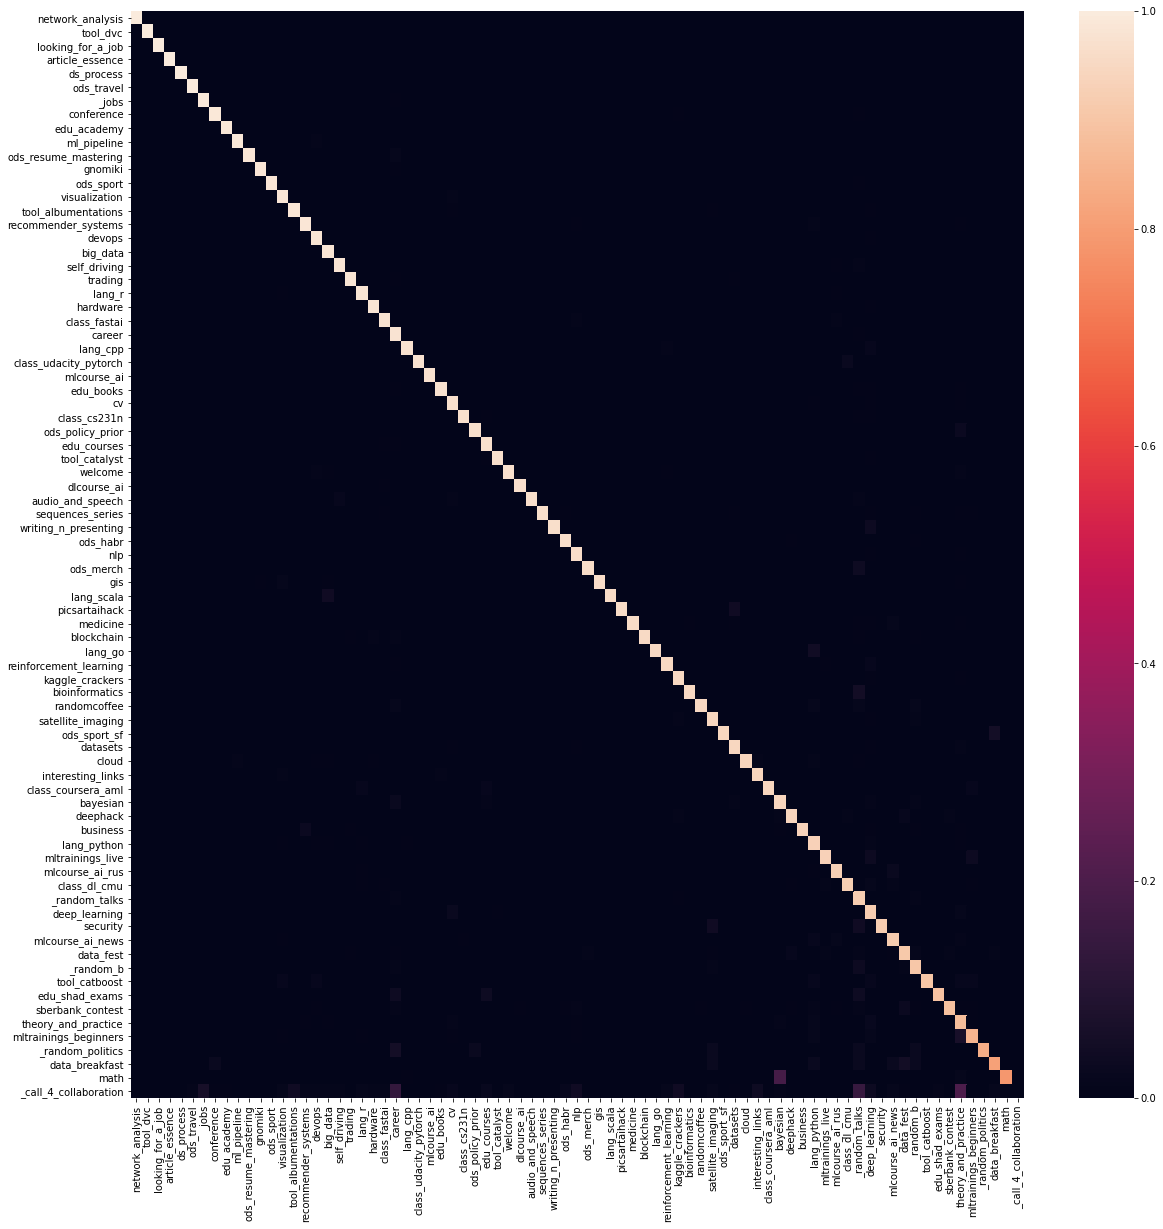

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(sorted_cm, vmax=1, xticklabels=sorted_annos, yticklabels=sorted_annos)

In [10]:
roc_auc_score(labels_max, preds_probas.cpu().numpy(), average='macro', multi_class='ovo')

0.9954741036064094

In [0]:
fig.savefig('drive/My Drive/Colab Notebooks/sbert_heatmap.svg')